In [3]:
import jax
from jax import numpy as jnp

jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt

from diffrax import Tsit5

from models import NeuralODE, MLPVectorField
from system import SystemTrajectoryGenerator, MetriplecticSystem
from train import Trainer

print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX devices: [CpuDevice(id=0)]
Default backend: cpu


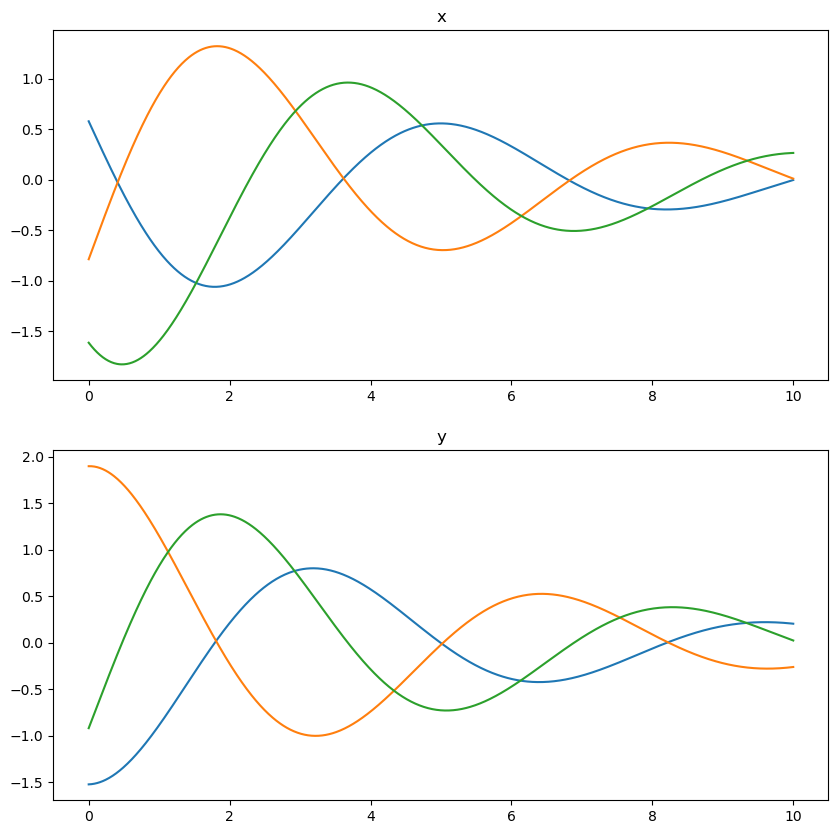

In [9]:
def vector_field(t,y,args):
    omega = 1.0
    zeta = 0.2
    return jnp.array([y[1],-(omega**2)*y[0]-2*zeta*omega*y[1]])

dim = 2
system = SystemTrajectoryGenerator(vector_field, dim, Tsit5(), ["x", "y"], args=())

key = jax.random.PRNGKey(42)
n_traj = 3
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([4,4]) + jnp.array([-2,-2])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()

In [10]:
key = jax.random.PRNGKey(42)
model = NeuralODE(MLPVectorField, system.dim, 64, 2, 0.01, key=key)
trainer = Trainer(system, model=model, lr=1e-3)
model, train_losses, valid_losses = trainer.train(N=2048, 
                                                  N_valid=4,
                                                  n_epochs=100, 
                                                  bs=32, 
                                                  bs_valid=2, 
                                                  mins=[-2,2], 
                                                  maxs=[2,2], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 10],
                                                  nrand=[100, 200],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

--------------------

Training until time 1.000100010001, with 100 samples.

--------------------
Epoch: 0
Train loss: 0.048377702563044966, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.005143458854118224, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.0028484959861312157, Valid loss: 0
--------------------
Epoch: 3
Train loss: 3.696682336423119e-05, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.005516035837289126, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.0008065240327000915, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.00021296952098964888, Valid loss: 0
--------------------
Epoch: 7
Train loss: 3.507466992335324e-05, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.0001262007790410449, Valid loss: 0
--------------------
Epoch: 9
Train loss: 1.1843806770577974e-05, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.002772735288251087, Valid loss: 0
Saving model at epoch 10
--------------------
Epoch: 11

In [ ]:
def SackurTetrode(S,Nkb,c_hat,V):
        return jnp.power(jnp.exp(S/Nkb)/(c_hat*V),2.0/3.0)

def M_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L, c_hat, A_char = args
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L - q)
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    factor = 9.0 * (Nkb**2) * alpha / 4.0
    
    M = jnp.zeros((4, 4), dtype=x.dtype)
    M = M.at[2, 2].set(factor / (E1**2))
    M = M.at[2, 3].set(-factor / (E1 * E2))
    M = M.at[3, 2].set(-factor / (E1 * E2))
    M = M.at[3, 3].set(factor / (E2**2))
    
    return M

def E_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L_, c_hat, A_char = args
    
    E_kin = p**2 / (2 * m)
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L_ - q)
    
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    return E_kin + E1 + E2

def S_gas(x, args):
    q, p, S1, S2 = x
    return S1 + S2

def L_gas(x, args):
    return jnp.array([
        [0.,  1., 0., 0.],
        [-1., 0., 0., 0.],
        [0.,  0., 0., 0.],
        [0.,  0., 0., 0.],
    ], dtype=x.dtype)

def gradE_gas(x, args):
    return jax.grad(lambda x_: E_gas(x_, args))(x)

def gradS_gas(x, args):
    return jax.grad(lambda x_: S_gas(x_, args))(x)

def two_gas_container(t, y, args):
    L = L_gas(y, args)
    M = M_gas(y, args)
    grad_E = gradE_gas(y, args)
    grad_S = gradS_gas(y, args)
    return L@grad_E + M@grad_S

Nkb = 1 # Number of particles and Boltzmann constant (characteristic unit of entropy)
m = 1 # Mass of wall
alpha = 8 # 
length = 1 # Distance from origin to the middle of the container (equilibrium wall position)
c_hat = 1 # Energy normalization
A_char = 1 # Average cross-sectional area
args = (Nkb, m, alpha, length, c_hat, A_char)

dim = 4
system = SystemTrajectoryGenerator(two_gas_container, dim, Tsit5(), ["x", "y"], args=())

key = jax.random.PRNGKey(42)
n_traj = 3
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([1.75, 2, 2.0, 2.0]) + jnp.array([0.0, -1.0, 1.0, 1.0])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()

[ 0.5         3.46182486 -2.03374889  4.23036818]


ValueError: Terms are not compatible with solver!

y0 shape:  (10, 4)
y0:  [1.20177854 0.0762731  1.77463682 2.86727315]
y_true shape:  (10, 10000, 4)
y_model shape:  (10, 10000, 4)
Loss:  1.3442598409838316e-09


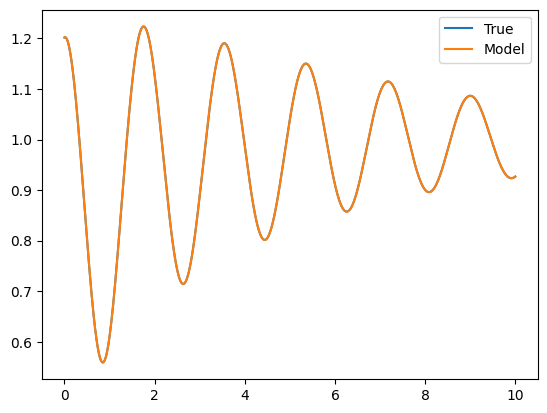

In [4]:
dim = 4
n_sample = 0
n_dim = 0
y0 = jax.random.uniform(key, (10,dim)) * jnp.array([1.0, 0.4, 2.0, 2.0]) + jnp.array([0.5, -0.2, 1, 1])
print("y0 shape: ", y0.shape)
print("y0: ", y0[n_sample,:])
t0 = 0.0
t1 = 10.0
dt = 1e-3
ts = np.linspace(t0,t1,int((t1-t0)/dt))

y_true = system.generate_trajectories(y0, t0, t1, dt)
y_model = jax.vmap(model, in_axes=(None, 0))(ts, y0)

print("y_true shape: ", y_true.shape)
print("y_model shape: ", y_model.shape)
print("Loss: ", jnp.mean((y_true - y_model) ** 2))

plt.plot(ts,y_true[n_sample,:,n_dim], label="True")
plt.plot(ts,y_model[n_sample,:,n_dim], label="Model")
plt.legend()